# Adversarial Example Generation

If you are reading this, hopefully you can appreciate how effective some machine learning models are. Research is constantly pushing ML models to be faster, more accurate, and more efficient. However, an often overlooked aspect of designing and training models is security and robustness, especially in the face of an adversary who wishes to fool the model.

This tutorial will raise your awareness to the security vulnerabilities of ML models, and will give insight into the hot topic of adversarial machine learning. You may be surprised to find that adding imperceptible perturbations to an image can cause drastically different model performance. Given that this is a tutorial, we will explore the topic via example on an image classifier. Specifically, we will use one of the first and most popular attack methods, the Fast Gradient Sign Attack (FGSM), to fool an MNIST classifier.

## Threat Model
For context, there are many categories of adversarial attacks, each with a different goal and assumption of the attacker’s knowledge. However, in general the overarching goal is to add the least amount of perturbation to the input data to cause the desired misclassification. There are several kinds of assumptions of the attacker’s knowledge, two of which are: white-box and black-box. A white-box attack assumes the attacker has full knowledge and access to the model, including architecture, inputs, outputs, and weights. A black-box attack assumes the attacker only has access to the inputs and outputs of the model, and knows nothing about the underlying architecture or weights. There are also several types of goals, including misclassification and source/target misclassification. A goal of misclassification means the adversary only wants the output classification to be wrong but does not care what the new classification is. A source/target misclassification means the adversary wants to alter an image that is originally of a specific source class so that it is classified as a specific target class.

In this case, the FGSM attack is a white-box attack with the goal of misclassification. With this background information, we can now discuss the attack in detail.

## Fast Gradient Sign Attack
One of the first and most popular adversarial attacks to date is referred to as the Fast Gradient Sign Attack (FGSM) and is described by Goodfellow et. al. in Explaining and Harnessing Adversarial Examples. The attack is remarkably powerful, and yet intuitive. It is designed to attack neural networks by leveraging the way they learn, gradients. The idea is simple, rather than working to minimize the loss by adjusting the weights based on the backpropagated gradients, the attack adjusts the input data to maximize the loss based on the same backpropagated gradients. In other words, the attack uses the gradient of the loss w.r.t the input data, then adjusts the input data to maximize the loss.

Before we jump into the code, let’s look at the famous FGSM panda example and extract some notation.

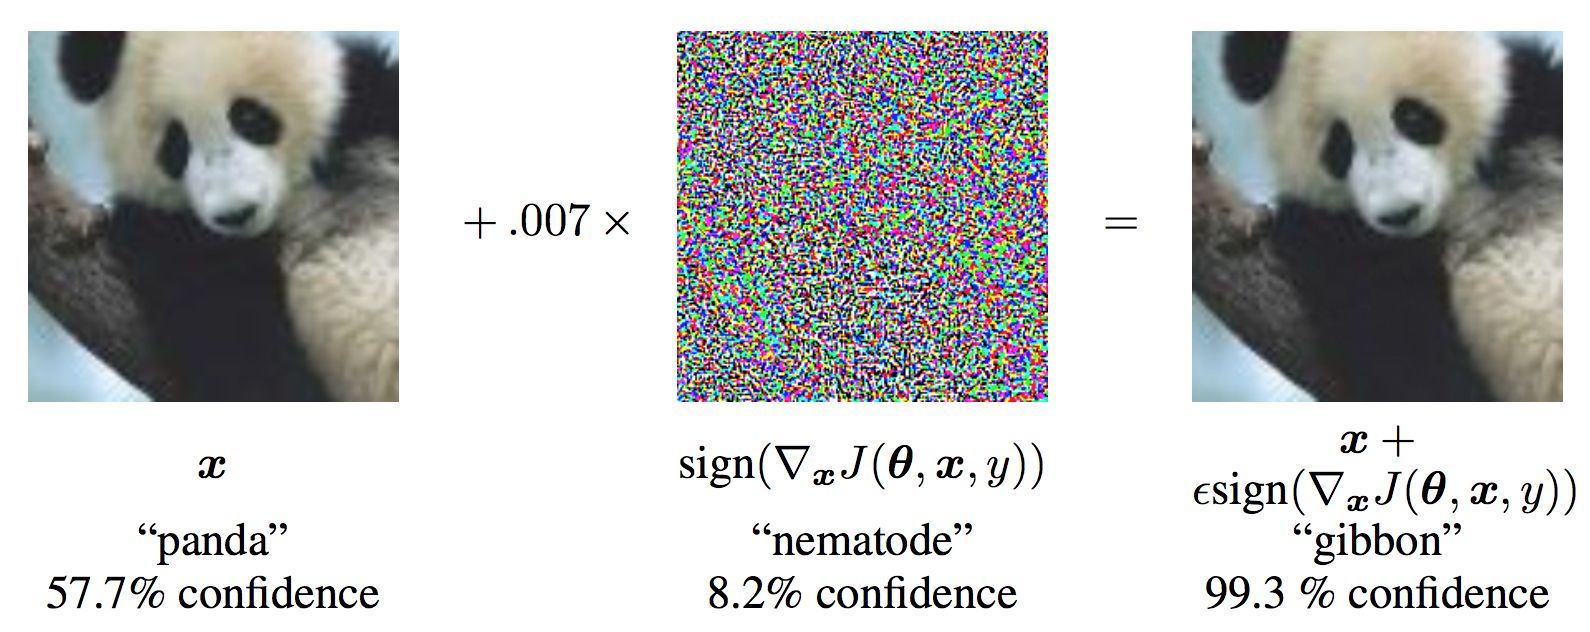

From the figure, X is the original input image correctly classified as a “panda”, y is the ground truth label for x,θ represents the model parameters, and J(θ,x,y) is the loss that is used to train the network. The attack backpropagates the gradient back to the input data to calculate ∇xJ(θ,x,y). Then, it adjusts the input data by a small step (ϵ or 0.007 in the picture) in the direction (i.e. sign(∇xJ(θ,x,y)) that will maximize the loss. The resulting perturbed image, x′, is then misclassified by the target network as a “gibbon” when it is still clearly a “panda”.

Hopefully now the motivation for this tutorial is clear, so lets jump into the implementation.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

## Implementation
In this section, we will discuss the input parameters for the tutorial, define the model under attack, then code the attack and run some tests.

## Inputs
There are only three inputs for this tutorial, and are defined as follows:
    epsilons - List of epsilon values to use for the run. It is important to keep 0 in the list because it represents the model performance on the original test set. Also, intuitively we would expect the larger the epsilon, the more noticeable the perturbations but the more effective the attack in terms of degrading model accuracy. Since the data range here is [0,1], no epsilon value should exceed 1.

pretrained_model - path to the pretrained MNIST model which was trained with pytorch/examples/mnist. For simplicity, download the pretrained model here. https://drive.google.com/file/d/1HJV2nUHJqclXQ8flKvcWmjZ-OU5DGatl/view

In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/lenet_mnist_model.pth"
# Set random seed for reproducibility
torch.manual_seed(42)

## Model Under Attack
As mentioned, the model under attack is the same MNIST model from pytorch/examples/mnist. You may train and save your own MNIST model or you can download and use the provided model. The Net definition and test dataloader here have been copied from the MNIST example. The purpose of this section is to define the model and dataloader, then initialize the model and load the pretrained weights.

In [3]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location=device, weights_only=True))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Using mps device


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## FGSM Attack
Now, we can define the function that creates the adversarial examples by perturbing the original inputs. The fgsm_attack function takes three inputs, image is the original clean image (x), epsilon is the pixel-wise perturbation amount (ϵ), and data_grad is gradient of the loss w.r.t the input image (∇x J(θ,x,y)). The function then creates perturbed image as

perturbed_image=image+epsilon∗sign(data_grad)=x+ϵ∗sign(∇x J(θ,x,y))

Finally, in order to maintain the original range of the data, the perturbed image is clipped to range [0,1].

In [4]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

## Testing Function
Finally, the central result of this tutorial comes from the test function. Each call to this test function performs a full test step on the MNIST test set and reports a final accuracy. However, notice that this function also takes an epsilon input. This is because the test function reports the accuracy of a model that is under attack from an adversary with strength ϵ. More specifically, for each sample in the test set, the function computes the gradient of the loss w.r.t the input data (data_grad), creates a perturbed image with fgsm_attack (perturbed_data), then checks to see if the perturbed example is adversarial. In addition to testing the accuracy of the model, the function also saves and returns some successful adversarial examples to be visualized later.

In [5]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

## Run Attack

The last part of the implementation is to actually run the attack. Here, we run a full test step for each epsilon value in the epsilons input. For each epsilon we also save the final accuracy and some successful adversarial examples to be plotted in the coming sections. Notice how the printed accuracies decrease as the epsilon value increases. Also, note the ϵ=0 case represents the original test accuracy, with no attack.



In [6]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9912 / 10000 = 0.9912
Epsilon: 0.05	Test Accuracy = 9605 / 10000 = 0.9605
Epsilon: 0.1	Test Accuracy = 8742 / 10000 = 0.8742
Epsilon: 0.15	Test Accuracy = 7104 / 10000 = 0.7104
Epsilon: 0.2	Test Accuracy = 4862 / 10000 = 0.4862
Epsilon: 0.25	Test Accuracy = 2693 / 10000 = 0.2693
Epsilon: 0.3	Test Accuracy = 1397 / 10000 = 0.1397


## Results
### Accuracy vs Epsilon
The first result is the accuracy versus epsilon plot. As alluded to earlier, as epsilon increases we expect the test accuracy to decrease. This is because larger epsilons mean we take a larger step in the direction that will maximize the loss. Notice the trend in the curve is not linear even though the epsilon values are linearly spaced. For example, the accuracy at ϵ=0.05 is only about 4% lower than ϵ=0, but the accuracy at ϵ=0.2 is 25% lower than ϵ=0.15. Also, notice the accuracy of the model hits random accuracy for a 10-class classifier between ϵ=0.25 and ϵ=0.3.



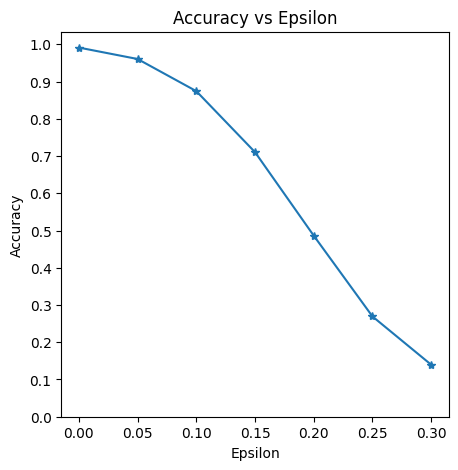

In [7]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## Sample Adversarial Examples
Remember the idea of no free lunch? In this case, as epsilon increases the test accuracy decreases BUT the perturbations become more easily perceptible. In reality, there is a tradeoff between accuracy degradation and perceptibility that an attacker must consider. Here, we show some examples of successful adversarial examples at each epsilon value. Each row of the plot shows a different epsilon value. The first row is the ϵ=0 examples which represent the original “clean” images with no perturbation. The title of each image shows the “original classification -> adversarial classification.” Notice, the perturbations start to become evident at ϵ=0.15 and are quite evident at ϵ=0.3. However, in all cases humans are still capable of identifying the correct class despite the added noise.

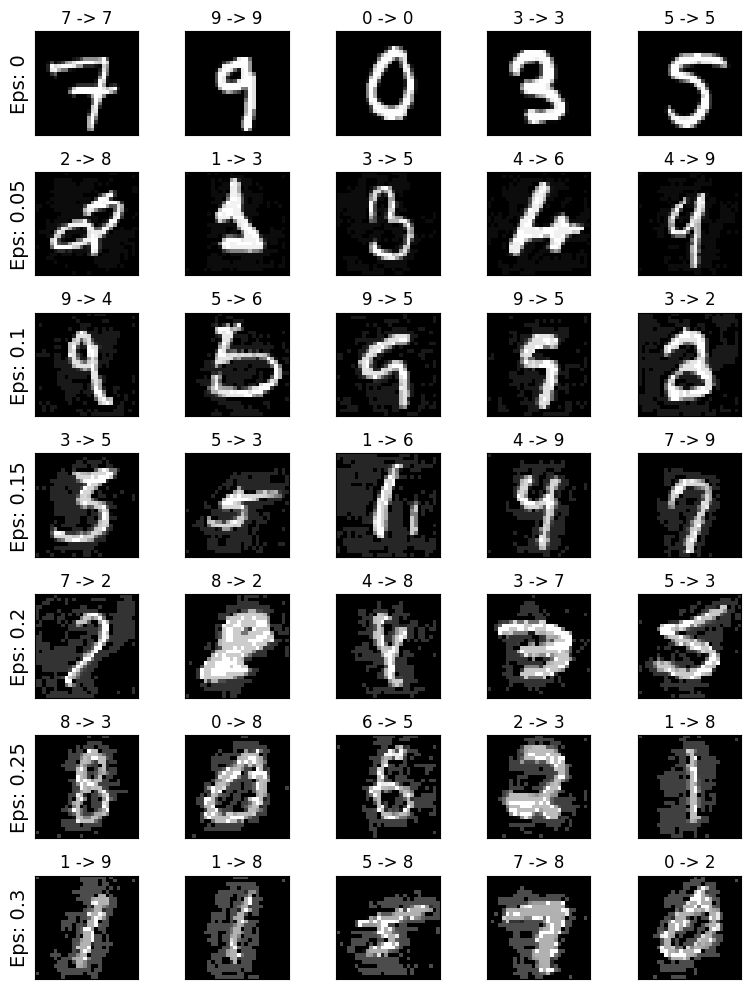

In [8]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

## Where to go next?
Hopefully this tutorial gives some insight into the topic of adversarial machine learning. There are many potential directions to go from here. This attack represents the very beginning of adversarial attack research and since there have been many subsequent ideas for how to attack and defend ML models from an adversary. In fact, at NIPS 2017 there was an adversarial attack and defense competition and many of the methods used in the competition are described in this paper: Adversarial Attacks and Defences Competition. The work on defense also leads into the idea of making machine learning models more robust in general, to both naturally perturbed and adversarially crafted inputs.

Another direction to go is adversarial attacks and defense in different domains. Adversarial research is not limited to the image domain, check out this attack on speech-to-text models. But perhaps the best way to learn more about adversarial machine learning is to get your hands dirty. Try to implement a different attack from the NIPS 2017 competition, and see how it differs from FGSM. Then, try to defend the model from your own attacks.

A further direction to go, depending on available resources, is to modify the code to support processing work in batch, in parallel, and or distributed vs working on one attack at a time in the above for each epsilon test() loop.